# Outline

## Bias baseline

RMSE overall & for user segments & for item segments

RMSE is smaller for more active users / more popular items

In [2]:
import pandas as pd
import json
from tqdm import tqdm
import numpy as np

from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
line_count = len(open("review.json").readlines())
user_ids, business_ids, stars, dates = [], [], [], []
with open("review.json") as f:
    for line in tqdm(f, total=line_count):
        blob = json.loads(line)
        user_ids += [blob["user_id"]]
        business_ids += [blob["business_id"]]
        stars += [blob["stars"]]
        dates += [blob["date"]]
ratings = pd.DataFrame(
{"user_id": user_ids, "business_id": business_ids, "rating": stars, "date": dates}
)
user_counts = ratings["user_id"].value_counts()
active_users = user_counts.loc[user_counts >= 5].index.tolist()

100%|██████████| 6685900/6685900 [01:14<00:00, 89324.30it/s] 


In [4]:
# Filter active users
ratings = ratings[ratings.user_id.isin(active_users)].sort_values(by=['user_id', 'date'])

In [4]:
# save and load the dataframe
#ratings.to_pickle('ratings.pkl')
#business.to_pickle('business.pkl')
ratings = pd.read_pickle('ratings.pkl')
#business = pd.read_pickle('business.pkl')
ratings.head()

,user_id,business_id,rating,date
5178360,---1lKK3aKOuomHnwAkAow,5cbsjFtrntUAeUx51FaFTg,4.0,2008-11-11 04:31:46
5934075,---1lKK3aKOuomHnwAkAow,--9e1ONYQuAa-CB_Rrw7Tw,4.0,2008-11-11 04:40:05
4312893,---1lKK3aKOuomHnwAkAow,ifEHr-ZnGFSKgJVsywiAFg,5.0,2009-01-16 21:49:36
2915094,---1lKK3aKOuomHnwAkAow,kosTPb88O4Q0XGbVbEOGCA,4.0,2010-10-16 23:27:02
809678,---1lKK3aKOuomHnwAkAow,rq5dgoksPHkJwJNQKlGQ7w,5.0,2010-10-16 23:31:28


In [4]:
# Number of active users
print("Number of active users:", len(active_users))

Number of active users: 286130


In [5]:
# Get review counts for items
item_counts = ratings["business_id"].value_counts()
items = item_counts.index.tolist()
# Number of items
print("Number of items:", len(items))

Number of items: 185723


## User Segmentation

We used the review count of a user to separate users into 3 groups: not so active, average and active.

In [12]:
# See distribution of users' review count
user_counts = ratings["user_id"].value_counts()
users = user_counts.index.tolist()
d = {'review_count' : user_counts}
activity = pd.DataFrame(d)
activity = activity.reset_index()
activity = activity.rename(columns={"index": "user_id"})

activity.head()

,user_id,review_count
0,CxDOIDnH8gp9KXzpBHJYXw,4129
1,bLbSNkLggFnqwNNzzq-Ijw,2354
2,PKEzKWv_FktMm2mGPjwd0Q,1822
3,ELcQDlf69kb-ihJfxZyL0A,1764
4,DK57YibC5ShBmqQl97CKog,1727


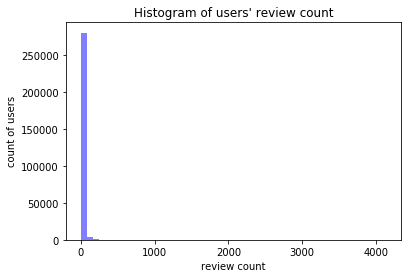

In [14]:
import matplotlib.pyplot as plt
num_bins = 50
plt.hist(user_counts, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('review count')
plt.ylabel('count of users')
plt.title(r"Histogram of users' review count")
plt.show()

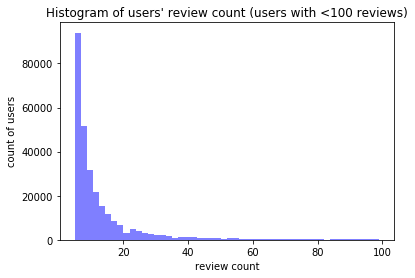

In [15]:
num_bins = 50
plt.hist(user_counts.loc[user_counts < 100], num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('review count')
plt.ylabel('count of users')
plt.title(r"Histogram of users' review count (users with <100 reviews)")
plt.show()

In [16]:
# summary statistics
activity.describe()

,review_count
count,286130.000000
mean,15.860874
std,32.607378
min,5.000000
25%,6.000000
50%,8.000000
75%,15.000000
max,4129.000000


In [14]:
# Split users into 3 segments based on review count
activity['label'] = pd.cut(activity['review_count'], bins=[5, 10, 20, float('Inf')], right = False,
                             labels=['not so active', 'average', 'very active'])

activity['label'].value_counts()

not so active    163306
average           74880
very active       47944
Name: label, dtype: int64

In [55]:
# obtain item counts
item_counts = ratings["business_id"].value_counts()
activity = pd.DataFrame({'review_count' : item_counts})
activity = activity.reset_index()
item_activity = activity.rename(columns={"index": "business_id"})

item_activity.head()

,business_id,review_count
0,4JNXUYY8wbaaDmk3BPzlWw,4627
1,RESDUcs7fIiihp38-d6_6g,4533
2,K7lWdNUhCbcnEvI0NhGewg,3877
3,DkYS3arLOhA8si5uUEmHOw,3388
4,FaHADZARwnY4yvlvpnsfGA,2931


In [56]:
item_activity.describe()

,review_count
count,185723.000000
mean,24.435703
std,74.189213
min,1.000000
25%,3.000000
50%,6.000000
75%,18.000000
max,4627.000000


In [65]:
# Group items into popular (>=300 ratings), moderate (10-300 ratings) and unpopular (<=10 ratings)
item_activity['label'] = pd.cut(item_activity['review_count'], bins=[0, 10, 300, float('Inf')], right = False,
                             labels=['unpopular', 'moderate', 'popular'])

item_activity['label'].value_counts()

unpopular    113330
moderate      70549
popular        1844
Name: label, dtype: int64

## Train and test split

In [5]:
# add integer user ID and item ID, ALS can only read interger user ID and item ID
ratings['user_code'] = ratings.user_id.astype('category').cat.codes
ratings['item_code'] = ratings.business_id.astype('category').cat.codes

# create dictionary (mapping)
user_dict = dict(zip(ratings.user_code, ratings.user_id))
item_dict = dict(zip(ratings.item_code, ratings.business_id))

In [6]:
# select the most recent rating as test, the rest as training
test = ratings.groupby('user_id').tail(1)
train = ratings.drop(test.index)

In [7]:
train.head()

,user_id,business_id,rating,date,user_code,item_code
5178360,---1lKK3aKOuomHnwAkAow,5cbsjFtrntUAeUx51FaFTg,4.0,2008-11-11 04:31:46,0,19063
5934075,---1lKK3aKOuomHnwAkAow,--9e1ONYQuAa-CB_Rrw7Tw,4.0,2008-11-11 04:40:05,0,5
4312893,---1lKK3aKOuomHnwAkAow,ifEHr-ZnGFSKgJVsywiAFg,5.0,2009-01-16 21:49:36,0,135553
2915094,---1lKK3aKOuomHnwAkAow,kosTPb88O4Q0XGbVbEOGCA,4.0,2010-10-16 23:27:02,0,141792
809678,---1lKK3aKOuomHnwAkAow,rq5dgoksPHkJwJNQKlGQ7w,5.0,2010-10-16 23:31:28,0,162126


## Bias baseline model

In [8]:
# overall average rating
overall_avg = train['rating'].mean()

In [9]:
# user bias
user_average = train.groupby('user_id')['rating'].mean()
userBias = pd.DataFrame(user_average) 
userBias['user_bias'] = userBias['rating'] - overall_avg
userBias = userBias.drop(columns=['rating'])
userBias.head()

,user_bias
user_id,
---1lKK3aKOuomHnwAkAow,0.259476
--0kuuLmuYBe3Rmu0Iycww,-0.293852
--2HUmLkcNHZp0xw6AMBPg,0.829727
--2vR0DIsmQ6WfcSzKWigw,0.369249
--3WaS23LcIXtxyFULJHTA,0.180174


In [10]:
# item bias
item_average = train.groupby('business_id')['rating'].mean()
itemBias = pd.DataFrame(item_average) 
itemBias['item_bias'] = itemBias['rating'] - overall_avg
itemBias = itemBias.drop(columns=['rating'])
itemBias.head()

,item_bias
business_id,
--1UhMGODdWsrMastO9DZw,0.501602
--6MefnULPED_I942VcFNA,-0.448398
--7zmmkVg-IMGaXbuVd0SQ,0.041076
--8LPVSo5i0Oo61X01sV9A,-0.748398
--9QQLMTbFzLJ_oT-ON3Xw,-0.384762


In [11]:
test[~test.business_id.isin(train.business_id)]

,user_id,business_id,rating,date,user_code,item_code
4568258,--RlSfc-QmcHFGHyX6aVjA,Oz1Ci9y2MnwYyAjVsoZg5Q,4.0,2018-11-04 07:01:17,24,75557
5334676,-0OE9Pn8vSK-WjJeRtHDtw,DiE8MZaW3c5LFg0e3YQXbg,5.0,2017-08-24 16:15:14,90,42690
4433002,-5SOwLPH9eLbTdTJrnjxgg,RZR6AYmF0RJAFmgj8I11Gg,1.0,2018-05-06 00:31:09,446,83044
4881890,-5i7xSNuaXWwODXqjEEEYQ,78op3fqT0itfTYbELGJvxg,4.0,2017-05-04 19:28:13,462,23436
3268040,-66F_Lt6WZrRua8ZAjXdqg,_5u--hWbsm3h6j3E_6P0mg,5.0,2018-08-02 03:15:02,490,107859
...,...,...,...,...,...,...
5452567,zwYCoSqLldPPL6409lySng,IhD8NkSLwF-207jxMOCY3Q,5.0,2018-04-17 19:23:12,285901,57302
4242219,zxEGx5TJcizUpbufPNusUQ,LfjgSONDpGF7RJOCv-r9Dg,5.0,2018-01-13 19:56:02,285947,65961
348347,zz-sXS6jNhVKJQUQtOrmXQ,S51hd1jI1SK7VCtOPkVN2Q,5.0,2016-01-12 21:01:18,286061,84535
403197,zzBuXG7J0QMrIZeHq-JfSg,OayEFsHTrtc_px-W9n3rWg,5.0,2015-03-14 16:44:28,286075,74428


Since some items in test data are not in training data, we simply fill in the item bias with 0.

In [12]:
# Making Prediction
predictions = test.join(userBias, on = 'user_id', how = 'left')
predictions = predictions.join(itemBias, on = 'business_id', how = 'left')
predictions = predictions.fillna(0)
predictions['pred_rating'] = predictions['user_bias'] + predictions['item_bias'] + overall_avg
predictions.head()

,user_id,business_id,rating,date,user_code,item_code,user_bias,item_bias,pred_rating
3928452,---1lKK3aKOuomHnwAkAow,Hqs4YNST_ZHbshwyi4bnsQ,5.0,2018-10-11 23:29:57,0,54831,0.259476,0.654828,4.662702
2794680,--0kuuLmuYBe3Rmu0Iycww,PYe_FDw6QTbTf66WcGE_tw,2.0,2014-04-21 16:58:28,1,77193,-0.293852,0.251602,3.706148
3722634,--2HUmLkcNHZp0xw6AMBPg,KW9RNyBPmc77f9FsO92qYw,5.0,2018-10-04 02:02:28,2,62566,0.829727,-0.733013,3.845112
1213261,--2vR0DIsmQ6WfcSzKWigw,BLIJ-p5wYuAhw6Pp6mh6mw,3.0,2018-01-11 04:24:17,3,35725,0.369249,-0.343060,3.774587
4737894,--3WaS23LcIXtxyFULJHTA,UKrfUw8quQiQM2N9i1nH0g,4.0,2018-09-03 19:32:11,4,91051,0.180174,0.918269,4.846840


### Rmse overall

In [58]:
y_predicted = np.array(predictions['pred_rating'])
y_actual = np.array(predictions['rating'])

rmse = sqrt(mean_squared_error(y_actual, y_predicted))
print("Bias baseline RMSE:", round(rmse,3))

Bias baseline RMSE: 1.392


### Rmse user segments

In [40]:
inactive_users = activity[activity['label'] == "not so active"].drop(columns = ["label", "review_count"])

inactive_pred = predictions[predictions.user_id.isin(inactive_users.user_id)]

average_users = activity[activity['label'] == "average"].drop(columns = ["label", "review_count"])

average_pred = predictions[predictions.user_id.isin(average_users.user_id)]

vactive_users = activity[activity['label'] == "very active"].drop(columns = ["label", "review_count"])

vactive_pred = predictions[predictions.user_id.isin(vactive_users.user_id)]

In [41]:
y_predicted = np.array(inactive_pred['pred_rating'])
y_actual = np.array(inactive_pred['rating'])

rmse = sqrt(mean_squared_error(y_actual, y_predicted))
print("Bias baseline RMSE (not so active users):", round(rmse,3))

y_predicted = np.array(average_pred['pred_rating'])
y_actual = np.array(average_pred['rating'])

rmse = sqrt(mean_squared_error(y_actual, y_predicted))
print("Bias baseline RMSE (average users):", round(rmse,3))

y_predicted = np.array(vactive_pred['pred_rating'])
y_actual = np.array(vactive_pred['rating'])

rmse = sqrt(mean_squared_error(y_actual, y_predicted))
print("Bias baseline RMSE (very active users):", round(rmse,3))

Bias baseline RMSE (not so active users): 1.437
Bias baseline RMSE (average users): 1.357
Bias baseline RMSE (very active users): 1.282


### Rmse item segments

In [66]:
unpopular_items = item_activity[item_activity['label'] == "unpopular"]["business_id"]

unpopular_pred = predictions[predictions.business_id.isin(unpopular_items)]

moderate_items = item_activity[item_activity['label'] == "moderate"]["business_id"]

moderate_pred = predictions[predictions.business_id.isin(moderate_items)]

popular_items = item_activity[item_activity['label'] == "popular"]["business_id"]

popular_pred = predictions[predictions.business_id.isin(popular_items)]

In [67]:
y_predicted = np.array(unpopular_pred['pred_rating'])
y_actual = np.array(unpopular_pred['rating'])

rmse = sqrt(mean_squared_error(y_actual, y_predicted))
print("Bias baseline RMSE (unpopular items):", round(rmse,3))

y_predicted = np.array(moderate_pred['pred_rating'])
y_actual = np.array(moderate_pred['rating'])

rmse = sqrt(mean_squared_error(y_actual, y_predicted))
print("Bias baseline RMSE (moderate items):", round(rmse,3))

y_predicted = np.array(popular_pred['pred_rating'])
y_actual = np.array(popular_pred['rating'])

rmse = sqrt(mean_squared_error(y_actual, y_predicted))
print("Bias baseline RMSE (popular items):", round(rmse,3))

Bias baseline RMSE (unpopular items): 1.641
Bias baseline RMSE (moderate items): 1.38
Bias baseline RMSE (popular items): 1.249


We observe that as the review count of users/items increases, the RMSE also decreases. This is reasonable since the baseline should be more accurate if we have more data on users/items.

# User Attributes

Next, we use the user dataset to see if there's any user attributes that we could include when building the model.

In [44]:
line_count = len(open("user.json").readlines())
user_ids, yelping_sinces = [], []
# usefuls, funnys, cools = [], [], []
fanss, elites = [], []
compliment_hots, compliment_mores, compliment_profiles, compliment_cutes = [], [], [], []
compliment_lists, compliment_notes, compliment_plains, compliment_cools = [], [], [], []
compliment_funnys, compliment_writers, compliment_photos = [], [], []
with open("user.json") as f:
    for line in tqdm(f, total=line_count):
        blob = json.loads(line)
        user_ids += [blob["user_id"]]
        #review_counts += [blob["review_count"]]
        yelping_sinces += [blob["yelping_since"]]
        fanss += [blob["fans"]] 
        elites += [blob["elite"]]
        compliment_hots += [blob["compliment_hot"]]
        compliment_mores += [blob["compliment_more"]]
        compliment_profiles += [blob["compliment_profile"]]
        compliment_cutes += [blob["compliment_cute"]]
        compliment_lists += [blob["compliment_list"]]
        compliment_notes += [blob["compliment_note"]]
        compliment_plains += [blob["compliment_plain"]]
        compliment_cools += [blob["compliment_cool"]]
        compliment_funnys += [blob["compliment_funny"]]
        compliment_writers += [blob["compliment_writer"]]
        compliment_photos += [blob["compliment_photos"]]

users = pd.DataFrame(
{"user_id": user_ids, "yelping_since": yelping_sinces, "fans": fanss, "elite": elites, 
"compliment_hot": compliment_hots, "compliment_more":compliment_mores, "compliment_profile": compliment_profiles,
"compliment_cute":compliment_cutes, "compliment_list":compliment_lists,
"compliment_note": compliment_notes, "compliment_plain": compliment_plains,
"compliment_cool": compliment_cools, "compliment_funny": compliment_funnys,
"compliment_writer": compliment_writers, "compliment_photos": compliment_photos}
)

100%|██████████| 1637138/1637138 [00:25<00:00, 63494.83it/s]


In [45]:
users.describe()

,fans,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
count,1.637138e+06,1.637138e+06,1.637138e+06,1.637138e+06,1.637138e+06,1.637138e+06,1.637138e+06,1.637138e+06,1.637138e+06,1.637138e+06,1.637138e+06,1.637138e+06
mean,1.465646e+00,2.242225e+00,3.325951e-01,2.135135e-01,1.902082e-01,8.358489e-02,1.503944e+00,3.090273e+00,3.106818e+00,3.106818e+00,1.165329e+00,1.138432e+00
std,1.568317e+01,8.021821e+01,1.367850e+01,1.626675e+01,1.269798e+01,1.089557e+01,6.327596e+01,9.211418e+01,8.823263e+01,8.823263e+01,3.268262e+01,9.549144e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,9.538000e+03,3.416700e+04,1.350000e+04,1.417300e+04,1.365400e+04,1.266900e+04,5.783300e+04,5.210300e+04,3.226600e+04,3.226600e+04,1.544200e+04,8.260200e+04


For all numerical variables, the 75th percentile is 0. Therefore, we do not include those as user attributes when we build the model.

In [46]:
# the 'elite' column
# replace blank value with nan
users['elite'] = users['elite'].replace(r'^\s*$', np.nan, regex=True).head()

# count number of nan in 'elite'
print("Number of NAs:", users['elite'].isna().sum())
print("Total number of observations:", len(users['elite']))

Number of NAs: 1637136
Total number of observations: 1637138


Since almost 100% of values in the `elite` column are missing, we decide to exclude it from our model.

In [47]:
# Compute number of years that a user has been using Yelp
users['year'] = 2019 - pd.DatetimeIndex(users['yelping_since']).year

In [69]:
users.head()

,user_id,yelping_since,fans,elite,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,year
0,l6BmjZMeQD3rDxWUbiAiow,2013-10-08 23:11:33,5,"2015,2016,2017",2,0,0,0,0,1,1,1,1,2,0,6
1,4XChL029mKr5hydo79Ljxg,2013-02-21 22:29:06,4,,1,0,0,0,0,0,0,1,1,0,0,6
2,bc8C_eETBWL0olvFSJJd0w,2013-10-04 00:16:10,0,,0,0,0,0,0,1,0,0,0,0,0,6
3,dD0gZpBctWGdWo9WlGuhlA,2014-05-22 15:57:30,5,,1,0,0,0,0,0,2,0,0,1,0,5
4,MM4RJAeH6yuaN8oZDSt0RA,2013-10-23 07:02:50,39,"2015,2016,2017,2018",28,1,0,0,1,16,57,80,80,25,5,6


In [48]:
# User attributes
user_attr = users[['user_id', 'year']] 
user_attr.head()

,user_id,year
0,l6BmjZMeQD3rDxWUbiAiow,6
1,4XChL029mKr5hydo79Ljxg,6
2,bc8C_eETBWL0olvFSJJd0w,6
3,dD0gZpBctWGdWo9WlGuhlA,5
4,MM4RJAeH6yuaN8oZDSt0RA,6
